## 1. Setup & Imports

In [357]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report
import gc

## 2. Load the Data

In [358]:
transaction_train_path = 'data/train_transaction.csv'
identity_train_path = 'data/train_identity.csv'
transaction_test_path = 'data/test_transaction.csv'
identity_test_path = 'data/test_identity.csv'

train_transaction = pd.read_csv(transaction_train_path)
train_identity = pd.read_csv(identity_train_path)
test_transaction = pd.read_csv(transaction_test_path)
test_identity = pd.read_csv(identity_test_path)

In [359]:
print("Train Transaction Shape:", train_transaction.shape)
print("Train Identity Shape:", train_identity.shape)
print("Test Transaction Shape:", test_transaction.shape)
print("Test Identity Shape:", test_identity.shape)

Train Transaction Shape: (590540, 394)
Train Identity Shape: (144233, 41)
Test Transaction Shape: (506691, 393)
Test Identity Shape: (141907, 41)


## 3. Merge Identity Tables

In [360]:
train_df = train_transaction.merge(train_identity, on='TransactionID', how='left')
test_df = test_transaction.merge(test_identity, on='TransactionID', how='left')

print("Merged Train Shape:", train_df.shape)
print("Merged Test Shape:", test_df.shape)

Merged Train Shape: (590540, 434)
Merged Test Shape: (506691, 433)


In [361]:
train_df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [362]:
test_df.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id-31,id-32,id-33,id-34,id-35,id-36,id-37,id-38,DeviceType,DeviceInfo
0,3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.00,W,4272,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.00,W,4476,574.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,284.95,W,10989,360.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.95,W,18018,452.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [363]:
print(train_df['isFraud'].value_counts(normalize=True))

isFraud
0    0.96501
1    0.03499
Name: proportion, dtype: float64


## 4. Data Preparation

In [364]:
pd.set_option('display.max_rows', None)
print(train_df.notnull().sum().head())

TransactionID     590540
isFraud           590540
TransactionDT     590540
TransactionAmt    590540
ProductCD         590540
dtype: int64


In [365]:
missing_df = train_df.isnull().mean().sort_values(ascending=False)
print(missing_df)

id_24             0.991962
id_25             0.991310
id_07             0.991271
id_08             0.991271
id_21             0.991264
id_26             0.991257
id_27             0.991247
id_23             0.991247
id_22             0.991247
dist2             0.936284
D7                0.934099
id_18             0.923607
D13               0.895093
D14               0.894695
D12               0.890410
id_03             0.887689
id_04             0.887689
D6                0.876068
id_33             0.875895
id_10             0.873123
id_09             0.873123
D9                0.873123
D8                0.873123
id_30             0.868654
id_32             0.868619
id_34             0.868248
id_14             0.864456
V142              0.861237
V158              0.861237
V140              0.861237
V162              0.861237
V141              0.861237
V161              0.861237
V157              0.861237
V146              0.861237
V156              0.861237
V155              0.861237
V

In [366]:
manual_cols = [
    'TransactionID', 'TransactionDT', 'TransactionAmt', 'ProductCD',
    'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
    'addr1', 'addr2', 'dist1', 'dist2',
    'P_emaildomain', 'R_emaildomain',
    'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14',
    'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15',
    'isFraud'
]

train_df = train_df[manual_cols]
test_df  = test_df[[col for col in manual_cols if col != 'isFraud']]

print(f"Subsetted train shape: {train_df.shape}")
print(f"Subsetted test shape:  {test_df.shape}")

Subsetted train shape: (590540, 46)
Subsetted test shape:  (506691, 45)


In [367]:
categorical_cols = ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain']
numerical_cols = [col for col in train_df.columns if col not in categorical_cols + ['isFraud']]

train_df[numerical_cols] = train_df[numerical_cols].fillna(0)
test_df[numerical_cols] = test_df[numerical_cols].fillna(0)

train_df[categorical_cols] = train_df[categorical_cols].fillna("unknown")
test_df[categorical_cols] = test_df[categorical_cols].fillna("unknown")

print("Train missing values:\n", train_df.isnull().sum().sort_values(ascending=False))
print("Test missing values:\n", test_df.isnull().sum().sort_values(ascending=False))
print(numerical_cols)

Train missing values:
 TransactionID     0
D5                0
C10               0
C11               0
C12               0
C13               0
C14               0
D1                0
D2                0
D3                0
D4                0
D6                0
TransactionDT     0
D7                0
D8                0
D9                0
D10               0
D11               0
D12               0
D13               0
D14               0
D15               0
C9                0
C8                0
C7                0
C6                0
TransactionAmt    0
ProductCD         0
card1             0
card2             0
card3             0
card4             0
card5             0
card6             0
addr1             0
addr2             0
dist1             0
dist2             0
P_emaildomain     0
R_emaildomain     0
C1                0
C2                0
C3                0
C4                0
C5                0
isFraud           0
dtype: int64
Test missing values:
 TransactionID     0
C8

In [368]:
# test_df['isFraud'] = np.nan

# print("train_df shape:", train_df.shape)
# print("test_df shape:", test_df.shape)

In [369]:
# combined_df = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)

# del train_df, test_df
# gc.collect()

# print("Combined shape:", combined_df.shape)
# print("NaNs in isFraud:", combined_df['isFraud'].isna().sum())
# print("Value counts in isFraud:\n", combined_df['isFraud'].value_counts(dropna=False))
# print("isFraud dtype:", combined_df['isFraud'].dtype)

In [370]:
# def sd(col, max_loss_limit=0.001, avg_loss_limit=0.001, na_loss_limit=0, n_uniq_loss_limit=0, fillna=0):
#     is_float = str(col.dtypes)[:5] == 'float'
#     na_count = col.isna().sum()
#     n_uniq = col.nunique(dropna=False)
#     try_types = ['float16', 'float32']

#     if na_count <= na_loss_limit:
#         try_types = ['int8', 'int16', 'float16', 'int32', 'float32']

#     for type in try_types:
#         col_tmp = col
#         if is_float and (str(type)[:3] == 'int'):
#             col_tmp = col_tmp.copy().fillna(fillna).round()
#         col_tmp = col_tmp.astype(type)
#         max_loss = (col_tmp - col).abs().max()
#         avg_loss = (col_tmp - col).abs().mean()
#         na_loss = np.abs(na_count - col_tmp.isna().sum())
#         n_uniq_loss = np.abs(n_uniq - col_tmp.nunique(dropna=False))

#         if max_loss <= max_loss_limit and avg_loss <= avg_loss_limit and na_loss <= na_loss_limit and n_uniq_loss <= n_uniq_loss_limit:
#             return col_tmp

#     return col

# def reduce_mem_usage_sd(df, deep=True, verbose=True, obj_to_cat=False):
#     numerics = ['int16', 'uint16', 'int32', 'uint32', 'int64', 'uint64', 'float16', 'float32', 'float64']
#     start_mem = df.memory_usage(deep=deep).sum() / 1024 ** 2

#     for col in df.columns:
#         col_type = df[col].dtypes
#         na_count = df[col].isna().sum()
#         n_uniq = df[col].nunique(dropna=False)

#         if col_type in numerics:
#             df[col] = sd(df[col])
#         elif col_type == 'object' and obj_to_cat:
#             df[col] = df[col].astype('category')

#         if verbose:
#             print(f'Column {col}: {col_type} -> {df[col].dtypes}, na={na_count}, uniq={n_uniq}')
#             if df[col].isna().sum() != na_count:
#                 print(f'NA count changed: {na_count} → {df[col].isna().sum()}')
#             if df[col].nunique(dropna=False) != n_uniq:
#                 print(f'Unique count changed: {n_uniq} → {df[col].nunique(dropna=False)}')

#     end_mem = df.memory_usage(deep=deep).sum() / 1024 ** 2
#     print(f'Memory usage reduced from {start_mem:.2f} MB to {end_mem:.2f} MB ({100 * (start_mem - end_mem) / start_mem:.1f}% reduction)')

#     return df


In [371]:
# combined_df = reduce_mem_usage_sd(combined_df, verbose=True)

In [372]:
# train_df = combined_df[combined_df['isFraud'].notna()].copy()
# test_df = combined_df[combined_df['isFraud'].isna()].drop(columns='isFraud').copy()

# print("Split train shape:", train_df.shape)
# print("Split test shape:", test_df.shape)
# train_df.head()
# test_df.head()

In [373]:
for df in [train_df, test_df]:
    df['DaysFromStart'] = np.floor(df['TransactionDT'] / (60 * 60 * 24)) - 1
    df['D1_days_ago'] = df['D1'] - df['DaysFromStart']

print(train_df[['TransactionDT', 'DaysFromStart', 'D1', 'D1_days_ago']].head())

   TransactionDT  DaysFromStart     D1  D1_days_ago
0          86400            0.0   14.0         14.0
1          86401            0.0    0.0          0.0
2          86469            0.0    0.0          0.0
3          86499            0.0  112.0        112.0
4          86506            0.0    0.0          0.0


In [374]:
train_df['uid'] = (
    train_df['ProductCD'].astype(str) + '_' + train_df['card1'].astype(str) + '_' + train_df['card2'].astype(str) + '_' + 
    train_df['card3'].astype(str) + '_' + train_df['card4'].astype(str) + '_' + train_df['card5'].astype(str) + '_' + 
    train_df['card6'].astype(str) + '_' + train_df['addr1'].astype(str) + '_' + train_df['D1_days_ago'].astype(str)
)

test_df['uid'] = (
    test_df['ProductCD'].astype(str) + '_' + test_df['card1'].astype(str) + '_' + test_df['card2'].astype(str) + '_' +
    test_df['card3'].astype(str) + '_' + test_df['card4'].astype(str) + '_' + test_df['card5'].astype(str) + '_' +
    test_df['card6'].astype(str) + '_' + test_df['addr1'].astype(str) + '_' + test_df['D1_days_ago'].astype(str)
)
uid_stats = train_df.groupby('uid')['isFraud'].agg(['count', 'sum']).reset_index()
uid_stats.columns = ['uid', 'uid_count', 'uid_fraud_sum']
print("UID stats shape:", uid_stats.shape)
print(uid_stats.head())

UID stats shape: (232298, 3)
                                                 uid  uid_count  uid_fraud_sum
0      C_10003_0.0_0.0_unknown_0.0_unknown_0.0_-89.0          1              0
1     C_10003_555.0_128.0_visa_226.0_debit_0.0_-89.0          4              0
2  C_1000_555.0_185.0_mastercard_224.0_debit_0.0_...          1              0
3  C_10022_555.0_117.0_mastercard_224.0_debit_0.0...          1              0
4    C_10023_111.0_150.0_visa_226.0_debit_0.0_-102.0          1              0


In [375]:
train_df = train_df.merge(uid_stats, on='uid', how='left')
test_df = test_df.merge(uid_stats, on='uid', how='left')

test_df[['uid_count', 'uid_fraud_sum']] = test_df[['uid_count', 'uid_fraud_sum']].fillna(0)
train_df.head()
test_df.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,D11,D12,D13,D14,D15,DaysFromStart,D1_days_ago,uid,uid_count,uid_fraud_sum
0,3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,...,203.0,0.0,0.0,0.0,409.0,212.0,207.0,W_10409_111.0_150.0_visa_226.0_debit_170.0_207.0,18.0,0.0
1,3663550,18403263,49.00,W,4272,111.0,150.0,visa,226.0,debit,...,634.0,0.0,0.0,0.0,634.0,212.0,-63.0,W_4272_111.0_150.0_visa_226.0_debit_299.0_-63.0,7.0,0.0
2,3663551,18403310,171.00,W,4476,574.0,150.0,visa,226.0,debit,...,136.0,0.0,0.0,0.0,97.0,212.0,-75.0,W_4476_574.0_150.0_visa_226.0_debit_472.0_-75.0,18.0,0.0
3,3663552,18403310,284.95,W,10989,360.0,150.0,visa,166.0,debit,...,242.0,0.0,0.0,0.0,242.0,212.0,-170.0,W_10989_360.0_150.0_visa_166.0_debit_205.0_-170.0,1.0,0.0
4,3663553,18403317,67.95,W,18018,452.0,150.0,mastercard,117.0,debit,...,22.0,0.0,0.0,0.0,22.0,212.0,-190.0,W_18018_452.0_150.0_mastercard_117.0_debit_264...,0.0,0.0


In [376]:
intermediate_cols = [
    'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'D1', 'D1_days_ago', 'DaysFromStart'
]

train_df = train_df.drop(columns=[col for col in intermediate_cols if col in train_df.columns])
test_df = test_df.drop(columns=[col for col in intermediate_cols if col in test_df.columns])

print("Remaining train columns:", train_df.columns.tolist())
print("Remaining test columns:", test_df.columns.tolist())

Remaining train columns: ['TransactionID', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'isFraud', 'uid', 'uid_count', 'uid_fraud_sum']
Remaining test columns: ['TransactionID', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'uid', 'uid_count', 'uid_fraud_sum']


In [377]:
X = train_df.drop(columns=['isFraud'])
y = train_df['isFraud']
print(X.head())
print(y.head())

   TransactionID  TransactionDT  TransactionAmt ProductCD  dist1  dist2  \
0        2987000          86400            68.5         W   19.0    0.0   
1        2987001          86401            29.0         W    0.0    0.0   
2        2987002          86469            59.0         W  287.0    0.0   
3        2987003          86499            50.0         W    0.0    0.0   
4        2987004          86506            50.0         H    0.0    0.0   

  P_emaildomain R_emaildomain   C1   C2  ...   D9   D10    D11  D12  D13  D14  \
0       unknown       unknown  1.0  1.0  ...  0.0  13.0   13.0  0.0  0.0  0.0   
1     gmail.com       unknown  1.0  1.0  ...  0.0   0.0    0.0  0.0  0.0  0.0   
2   outlook.com       unknown  1.0  1.0  ...  0.0   0.0  315.0  0.0  0.0  0.0   
3     yahoo.com       unknown  2.0  5.0  ...  0.0  84.0    0.0  0.0  0.0  0.0   
4     gmail.com       unknown  1.0  1.0  ...  0.0   0.0    0.0  0.0  0.0  0.0   

     D15                                                uid  u

In [378]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [379]:
from sklearn.preprocessing import LabelEncoder

obj_cols = X_train.select_dtypes(include=['object']).columns.tolist()
print("Object columns:", obj_cols)

for col in obj_cols:
    le = LabelEncoder()
    le.fit(pd.concat([X_train[col], X_val[col]], axis=0).astype(str))

    X_train[col] = le.transform(X_train[col].astype(str))
    X_val[col]   = le.transform(X_val[col].astype(str))

categorical_features = obj_cols


Object columns: ['ProductCD', 'P_emaildomain', 'R_emaildomain', 'uid']


In [386]:
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation

model = lgb.LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.06,
    num_leaves=64,
    class_weight='balanced',
    random_state=42
)

model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    callbacks=[
        early_stopping(stopping_rounds=50),
        log_evaluation(period=100)
    ]
)


[LightGBM] [Info] Number of positive: 16530, number of negative: 455902
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009734 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8411
[LightGBM] [Info] Number of data points in the train set: 472432, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.0309422
[200]	valid_0's binary_logloss: 0.0228771
[300]	valid_0's binary_logloss: 0.0197434
[400]	valid_0's binary_logloss: 0.0177333
[500]	valid_0's binary_logloss: 0.0162709
[600]	valid_0's binary_logloss: 0.015231
[700]	valid_0's binary_logloss: 0.0144922
[800]	valid_0's binary_logloss: 0.0138628
[900]	valid_0's binary_logloss: 0.0133175
[100

,boosting_type,'gbdt'
,num_leaves,64
,max_depth,-1
,learning_rate,0.06
,n_estimators,1000
,subsample_for_bin,200000
,objective,None
,class_weight,'balanced'
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [387]:
y_pred_proba = model.predict_proba(X_val)[:, 1]
y_pred = model.predict(X_val)

print("AUC:", roc_auc_score(y_val, y_pred_proba))
print(classification_report(y_val, y_pred))


AUC: 0.9994813883854279
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    113975
           1       0.91      0.96      0.94      4133

    accuracy                           1.00    118108
   macro avg       0.96      0.98      0.97    118108
weighted avg       1.00      1.00      1.00    118108



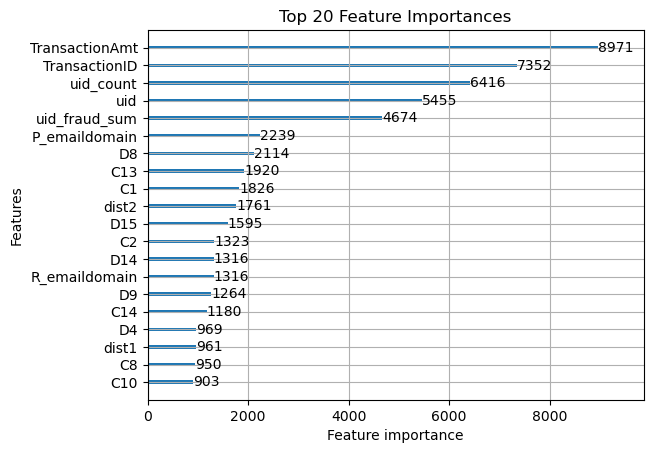

In [388]:
import matplotlib.pyplot as plt
import lightgbm as lgb

lgb.plot_importance(model, max_num_features=20)
plt.title("Top 20 Feature Importances")
plt.show()

In [389]:
# cat_cols = ['ProductCD', 'P_emaildomain', 'R_emaildomain', 'uid']

In [390]:
for col in categorical_features:
    le = LabelEncoder()
    le.fit(pd.concat([X_train[col], X_val[col], test_df[col]], axis=0).astype(str))

    X_train[col] = le.transform(X_train[col].astype(str))
    X_val[col]   = le.transform(X_val[col].astype(str))
    test_df[col] = le.transform(test_df[col].astype(str))

In [391]:
features = X_val.columns.tolist()
test_probs = model.predict_proba(test_df[features])[:, 1]
submission = pd.DataFrame({
    'TransactionID': test_df['TransactionID'],
    'isFraud': test_probs
})
submission.to_csv('submission.csv', index=False)